# Superoperator Formalism

Here, I present a way to represent the effect of a pulse as a matrix, massively speeding up computation, and allowing more detailed error analysis.

We start with a recounting of the basics, considering a single $n$-level qubit. A pure state (ket) of this qubit $\ket{\psi}$ exists in an $n$-dimensional Hilbert space, and is represented by a vector of length $n$. An operator is a map from $\mathcal{H}_n\to\mathcal{H}_n$, and is a map from kets to other kets.

If we now include mixed states, allowing for non-unitary evolution, we must change formalism. Now, a state is represented by a *density operator* $\rho=\ket{\psi}\bra{\psi}$, which is represented as an $n\times n$ matrix. This is why they are also known as *density matrices*.

> It can be seen that some of the operators in the pure formalism can be seen as density matrices representing states. For example, the $X90$ operator corresponds to the state $\ket{0}+\ket{1}$.

The question is then how do we operate on these density matrices? A naïve way would be to simply change the way they operate:

$$A\ket{\psi}\to A\rho A^\dag$$

However, this does not offer much insight into the process. A better way is to use a representation known as a Pauli Transfer Matrix.

## PTMs

> Go over this - in particular, why have the dimensions changed, and why is it a 4x4 matrix?

Consider a linear map $\rho \to \Lambda(\rho)$, acting on a Hilbert space which has some basis $P$. In 2D, this can be the Pauli set. For higher dimensions, we use the `generate_basis` function from `helpers.py`.

Then, we have a change of dimension: density matrices, which were $n\times n$ matrices, become vectors of length $n^2$ on a Hilbert space $\mathcal{H}_{n^2}$, and are written as superkets $\ket{\rho}\rangle$. Operators become superoperators, and are represented by matrices of dimension $n^2\times n^2$.

Under this formalism, we can derive something called the Pauli Transfer Matrix:

$$\left(R_\Lambda\right)_{ij}=\frac{1}{n}\text{Tr }\left[P_i\Lambda\left(P_j\right)\right]$$

And we find that

$$\ket{\Lambda(\rho)}\rangle=R_\Lambda \ket{\rho}\rangle$$

That is, the superket after the map is found by multiplying the PTM by the superket before the map. This means if we can find the PTM for a given map (by finding the result of its application to the basis vectors) then we can find the result of the operation for *any* initial state.

The question is now how to transfer from density matrices and operators to superkets and superoperators. We use a decomposition method to *vectorise* the matrices.

That is, the superket is a *vector* of length $n^2$ which has elements

$$\ket{\rho}\rangle_i=\langle\braket{k|\rho}\rangle=\text{Tr }P_k\rho$$

Where $k\equiv P_k$. That is, decompose the matrix $\rho$ into the basis $P$, and then the superket represents these coefficients.

For example,

$$\ket{\rho}\rangle=\begin{pmatrix}0.5\\0\\0.2\\0.3\end{pmatrix}\implies \rho =0.5P_0+0P_1+0.2P_2+0.3P_3$$

### Key Properties

The PTM has a number of key properties which make it useful.

 - The elements satisfy $(R_\Lambda)_{ij}\in\mathbb{R}, (R_\Lambda)_{ij}\in[-1, 1]$
 - The PTM of some composite map is equal to the product of the individual PTMs, which makes simulating a circuit easy

Then, all maps $\Lambda$ must be CPTP (completely positive (positive probabilities) and trace-preserving (probabilities add to 1)). This puts two requirements on $R_\Lambda$:

$$\left(R_\Lambda\right)_{0j}=\delta_{0j}=(1,0,0,\dots,0)$$

The second requirement is that we require $\rho_\Lambda$ to be positive semi-definite, where

$$\rho_\Lambda=\frac{1}{d^2}\sum_{i,j=1}^{d^2}{(R_\Lambda)_{ij}P_j^T\otimes P_i}$$

The map may also be unital, which means that it maps the identity to the identity, or equivalently, it does not make a state more pure. This can be visualised as the requirement that the zero vector on the Bloch sphere (maximally mixed state) is not mapped to a nonzero vector (less mixed state). If the map is unital, we find that the first *column* of $R_\Lambda$ satisfies

$$R_{i0}=\delta_{i0}=\begin{pmatrix}1\\0\\0\\\vdots\\0\end{pmatrix}$$

## Errors

does error analysis require me to change from a PTM to a process matrix?

## Algorithm

The algorithm I will use is as follows

1. Set up a transmon with some defined parameters
2. Using pulse-level simulation, find the optimal pulse parameters to execute an X90 pulse. Initially start with $\ket{0}$, but once the pulse is near-optimal, simulate a random starting state
3. Calculate the PTM by running the pulse on all of the basis states
4. Verify the PTM by comparing the simulated and pulse-level result for some initial state
5. Analyse the PTM to correlate error sources and types?

Discuss this plan with Peter.

## Notes

The inner product of two vectors or matrices is defined as

$$\braket{A|B}\text{ or }\langle\braket{A|B}\rangle = \text{Tr } A^\dag B$$

And the expected value of any operator is

$$\braket{E}=\text{Tr }E\rho$$

In [1]:
from superoperators import *
from helpers import *
from qutip import *
from simulate import *
from transmon import Transmon
import numpy as np
import pickle

In [2]:
# setup the PTM
tr = Transmon(n_levels=8, initial_state=0, Ω=5000, α=-100, RWA=True, dt=1/1000)
tr.X90_args = {'A': 7.449877548484732, 'Γ': 0.5024320350942441, 'ω': tr.Ω, 'A_DRAG': -0.0034947574297965116}

PTM = PTMs(tr.n_levels)
X90_PTM_ideal = PTM.ideal_PTM("X90")

In [ ]:
# check the transmon behaves as expected
# _ = simulate(tr, tr.X90_args, plot=True)

In [ ]:
# learn the X90 PTM

# X90_PTM = PTM.learn_X90_PTM(tr)

In [ ]:
# save everything
with open("transmon_PTMs", "wb") as f:
    pickle.dump([tr, X90_PTM], f)

In [3]:
# load everything
with open("transmon_PTMs", "rb") as f:
    tr, X90_PTM = pickle.load(f)

Performing simulation...
Calculating via PTMs...


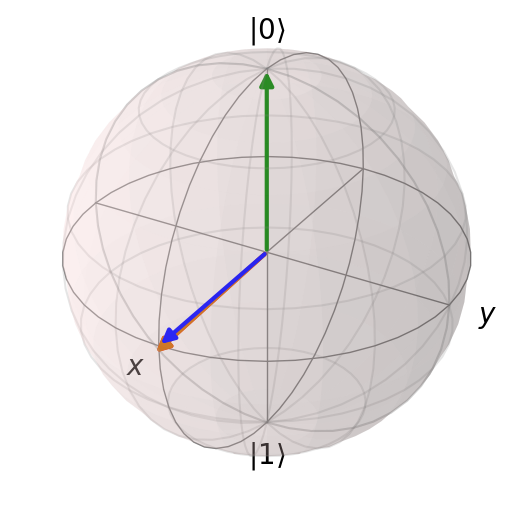

In [4]:
# check a single gate runs as expected

gate = "Y90"
g = U(gate_angles[gate])

# via simulation
print("Performing simulation...")
res_sim, _ = simulate_circuit(tr, g, plot=False)

# via ideal PTM
print("Calculating via PTMs...")
gate_PTM = PTM.ideal_PTM(gate)
res_PTM1 = PTM.apply_PTM(gate_PTM, tr.ψ0)

# via decomposition
circ_PTM = PTM.circuit_PTM(gate, X90_PTM)
res_PTMc = PTM.apply_PTM(circ_PTM, tr.ψ0)

plot_bloch(truncate([tr.ψ0, res_sim, res_PTM1, res_PTMc]))

In [5]:
print(res_sim.norm(), res_PTMc.norm())
print(fidelity(res_sim, res_PTMc))

1.0019017700026802 1.0003009986191898
1.0003389691924727


In [13]:
X90_PTM

Quantum object: dims = [[64], [64]], shape = (64, 64), type = oper, isherm = False
Qobj data =
[[ 4.99976237e-01+0.00000000e+00j  4.99985940e-01+0.00000000e+00j
  -2.68481315e-07+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 5.00024268e-01+0.00000000e+00j  5.00015861e-01+0.00000000e+00j
   2.64164802e-07+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [-5.05494077e-07+0.00000000e+00j -1.80481119e-06+0.00000000e+00j
   1.00000002e+00+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 ...
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ... -9.80929051e-01+6.55031585e-15j
   1.74865739e-06-9.77941955e-17j -7.46692602e-12+1.75331304e-18j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00

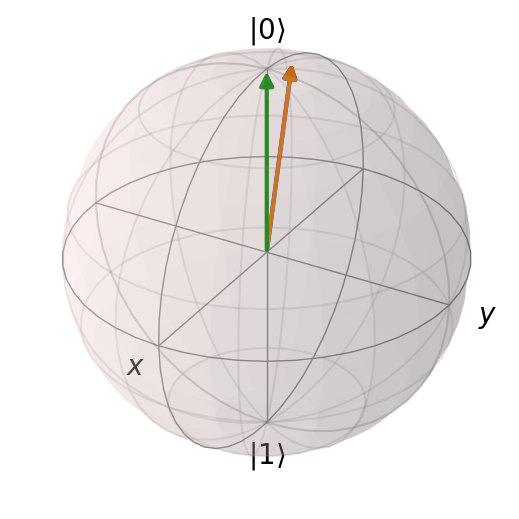

In [6]:
# check a circuit works as expected

circ = ["X90", "Z90", "Y90", "X180"]

# via pulse simulation
res_sim, _ = simulate_circuit(tr, circ, plot=False)

# via circuit decomposition
circ_PTM = PTM.circuit_PTM(circ, X90_PTM)
res_PTM = PTM.apply_PTM(circ_PTM, tr.ψ0)

plot_bloch(truncate([tr.ψ0, res_sim, res_PTM]))

In [7]:
# calculate the error gate
error_gate = X90_PTM * PTM.ideal_PTM("X270")#.inv()
Qobj(np.eye(error_gate.dims[0][0])) - error_gate
error_gate

Quantum object: dims = [[64], [64]], shape = (64, 64), type = oper, isherm = False
Qobj data =
[[ 9.99763913e-01  1.98264817e-04  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.37216944e-04  9.99802912e-01  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.13195823e-06 -1.17834704e-06  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]

Testing length 1000
1 
[0.8287595898195946]


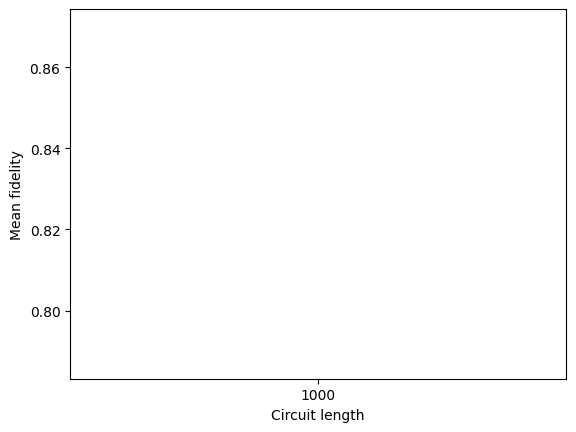

In [9]:
# perform RBT
lengths = [1000]

f = PTM.RBT_PTM(tr, X90_PTM, lengths, 1)

In [12]:
PTM.circuit_PTM(RBT_circuit(1000), X90_PTM)

KeyboardInterrupt: 